In [1]:
%matplotlib inline

In [37]:
import pandas as pd
import numpy as np
import time
import datetime
import os
import matplotlib.pyplot as plt

In [3]:
from scipy.optimize import minimize

In [4]:
from sklearn.metrics import r2_score

In [5]:
import json

# import data 

In [6]:
daily_data_dir = './../data/daily_data/'

In [7]:
daily_data = pd.read_csv(os.path.join(daily_data_dir, 'daily_data_clean_20171104.csv'), encoding='utf-8')

In [8]:
fund_code_list = daily_data['code'].unique().tolist()

In [9]:
print 'There are {} funds in total.'.format(len(fund_code_list))

There are 416 funds in total.


In [10]:
daily_data.columns

Index([u'code', u'date', u'year', u'month', u'day', u'return', u'sh300_return',
       u'zhongzheng_100_return', u'zhongzhai_composite_return',
       u'zhongzhai_total_return', u'zhongzheng_500_return',
       u'zhongzhai_short_term_return', u'zhongzhai_long_term_return',
       u'zhongzhai_short_AA_return'],
      dtype='object')

In [26]:
def fund_style_coef(fund_data, fund_style_list, target, interval, print_shape=False):
    """
        Given fund code and interval, return the coefficient
    """
    fund_coef_dict = {}
    for year in fund_data['year'].unique().tolist():
        tmp = fund_data[fund_data['year'] == year]
        for epoch in tmp[interval].unique().tolist():
            data = tmp[tmp[interval] == epoch]
            X = data.as_matrix(fund_style_list)
            X = X.T
            y = data.as_matrix([target])
            y = np.ravel(y)
            if print_shape:
                print 'code: {}, X:{}, y:{}'.format(data['code'], X.shape, y.shape)
            x0 = np.zeros(X.shape[0])
    
            def loss(x):
                return np.sum(np.square(np.dot(x,X) - y))
    
            cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1.0})
    
            x0 = np.zeros(X.shape[0])
            res = minimize(loss, x0, method='SLSQP', constraints=cons,
                  bounds=[(0, np.inf) for i in range(X.shape[0])], options={'disp':False})
            y_pred = np.dot(res.x, X)
            r_squared = r2_score(y, y_pred)
            # put ceof into a dict
            fund_coef_dict[str(year)+'-'+str(epoch)] = {'r_squared':r_squared}
            for i in xrange(len(fund_style_list)):
                fund_coef_dict[str(year)+'-'+str(epoch)][fund_style_list[i]+'_coef'] = res.x[i]
   
    fund_style_coef_list = []
    for i in fund_style_list:
        fund_style_coef_list += [i+'_coef']
    return pd.DataFrame(fund_coef_dict).T, fund_style_coef_list


In [34]:
def alpha_calculate(fund_data, fund_style_list, target, benchmark_index, interval, coef):
    """
        Given benchmark, return the select alpha and style alpha
    """
    
    total_alpha = []
    select_alpha = []
    style_alpha = []
    
    #merge fund_data and coef
    coef['date'] = coef.index 
    coef['year'] = coef['date'].apply(lambda x: int(x[:4]))
    coef[interval] = coef['date'].apply(lambda x: int(x[5:]))
    del coef['date']
    fund_data = pd.merge(fund_data, coef, on=['year', interval])
    
    fund_style_coef_list = []
    for i in fund_style_list:
            fund_style_coef_list +=[i+'_coef']
    for year in fund_data['year'].unique().tolist():
        tmp = fund_data[fund_data['year'] == year]
        for epoch in tmp[interval].unique().tolist():
            data = tmp[tmp[interval] == epoch]
            coef_i = data.as_matrix(fund_style_coef_list)
            X_i = data.as_matrix(fund_style_list)
            fund_style_return_i = np.sum(np.multiply(X_i, coef_i), axis=1)
            
            total_alpha_i = data[target] - data[benchmark_index]
            style_alpha_i = fund_style_return_i - data[benchmark_index]
            select_alpha_i = data[target] - fund_style_return_i
            total_alpha += [np.mean(total_alpha_i)]
            style_alpha += [np.mean(style_alpha_i)]
            select_alpha += [np.mean(select_alpha_i)]
    
    return total_alpha, select_alpha, style_alpha
#             print np.sum(np.multiply(X_i, coef_i), axis=1).shape, data[target].shape
#             print X_i
#             fund_style_return = np.dot(X_i, coef_i.T)

In [121]:
def fund_nv(fund_data, target, interval, benchmark_index):
    """
        Given benchmark and interval, return nv values
    """
    target_values = []
    benchmark_values = []
    
    nv_tar = 1.0
    nv_bench = 1.0
    for year in fund_data['year'].unique().tolist():
        tmp = fund_data[fund_data['year'] == year]
        for epoch in tmp[interval].unique().tolist():
            data = tmp[tmp[interval] == epoch]
            for tar, bench in data[[target, benchmark_index]].values:
                nv_tar *= (1 + tar)
                nv_bench *= (1 + bench)
                if nv_tar > 5:
                    print tar
#                 print nv_tar , tar
#             print 
#             print nv_tar
           
            target_values.append(nv_tar)
            benchmark_values.append(nv_bench)
    return target_values, benchmark_values

# select one ideal fund

In [17]:
fund_style_index_list = daily_data.columns[6:]
#select one fund
test_fund_data = daily_data[daily_data['code'] == fund_code_list[5]]
test_fund_data = test_fund_data.dropna(how='any')
benchmark = 'sh300_return'

Index([u'sh300_return', u'zhongzheng_100_return',
       u'zhongzhai_composite_return', u'zhongzhai_total_return',
       u'zhongzheng_500_return', u'zhongzhai_short_term_return',
       u'zhongzhai_long_term_return', u'zhongzhai_short_AA_return'],
      dtype='object')

# monthly regression

In [30]:
test_fund_data_month = test_fund_data
df_month, fund_style_coef_list = fund_style_coef(test_fund_data_month, fund_style_index_list, 'return', 'month')

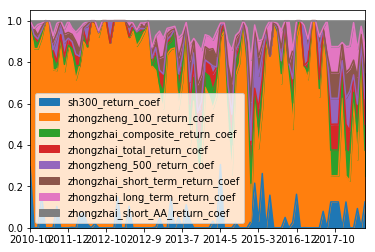

In [31]:
# df_month[fund_style_index_list].plot(kind='area')
df_month[fund_style_coef_list].plot(kind='area')

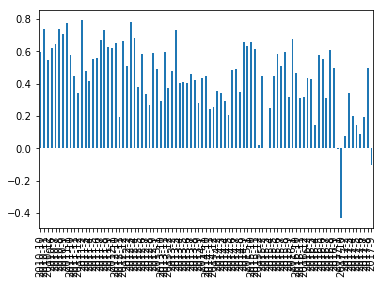

In [32]:
# df['r_squared'].plot()
df_month['r_squared'].plot(kind='bar')

In [35]:
total_alpha, select_alpha, style_alpha = alpha_calculate(test_fund_data_month,
                                        fund_style_index_list, 'return', benchmark, 'month', df_month)
# test_fund_data.head()

<Container object of 89 artists>

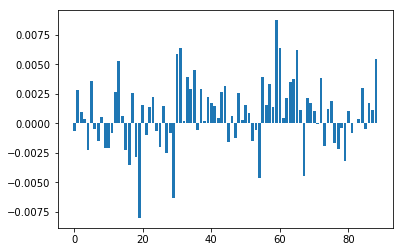

In [38]:
plt.bar(range(len(select_alpha)), select_alpha)

<Container object of 89 artists>

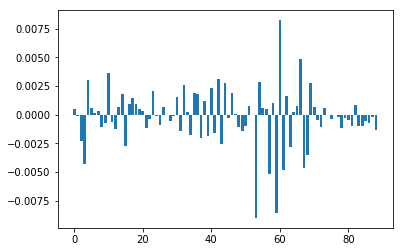

In [39]:
plt.bar(range(len(style_alpha)), style_alpha)

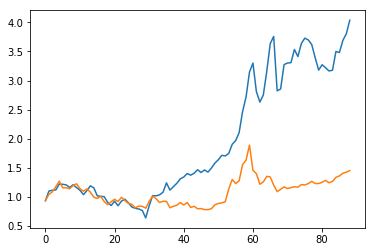

In [127]:
target_values, benchmark_values = fund_nv(test_fund_data_month, 'return', 'month', benchmark)
plt.plot(target_values)
plt.plot(benchmark_values)

# seasonly regression

In [40]:
def get_season(daily_data):
    if daily_data in [1,2,3]:
        return 1
    elif daily_data in [4,5,6]:
        return 2
    elif daily_data in [7,8,9]:
        return 3
    else:
        return 4
        

In [41]:
test_fund_data_season = test_fund_data
test_fund_data_season['season'] = test_fund_data['month'].apply(get_season)

In [44]:
df_season, fund_style_coef_list = fund_style_coef(test_fund_data_season, fund_style_index_list, 'return', 'season')

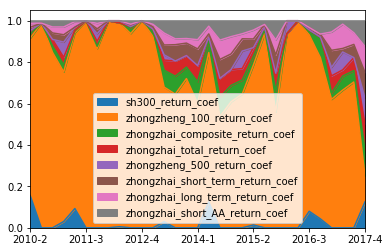

In [45]:
df_season[fund_style_coef_list].plot(kind='area')

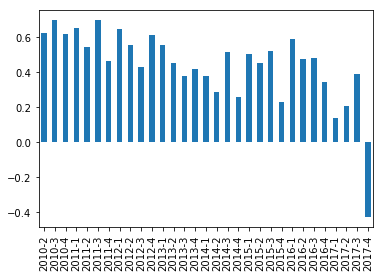

In [46]:
df_season['r_squared'].plot(kind='bar')

In [47]:
total_alpha, select_alpha, style_alpha = alpha_calculate(test_fund_data_season, 
                                        fund_style_index_list, 'return', benchmark, 'season', df_season)
# test_fund_data.head()

<Container object of 31 artists>

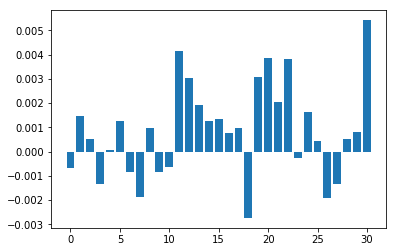

In [48]:
plt.bar(range(len(select_alpha)), select_alpha)

<Container object of 31 artists>

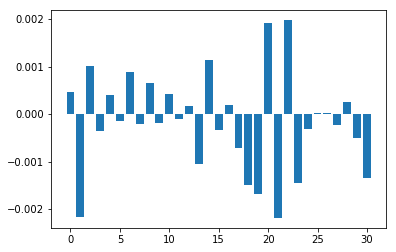

In [49]:
plt.bar(range(len(style_alpha)), style_alpha)

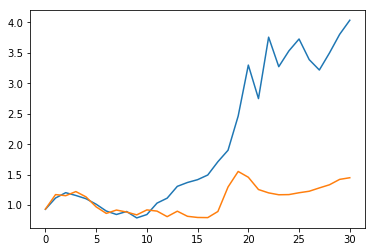

In [128]:
target_values, benchmark_values = fund_nv(test_fund_data_season, 'return', 'season', benchmark)
plt.plot(target_values)
plt.plot(benchmark_values)

# half-year regression

In [50]:
def get_half_year(data):
    if data in range(1, 7):
        return 1
    else:
        return 2

In [51]:
test_fund_data_half_year = test_fund_data
test_fund_data_half_year['half_year'] = test_fund_data['month'].apply(get_half_year)

In [52]:
df_half_year, fund_style_coef_list= fund_style_coef(test_fund_data_half_year, fund_style_index_list, 'return', 'half_year')

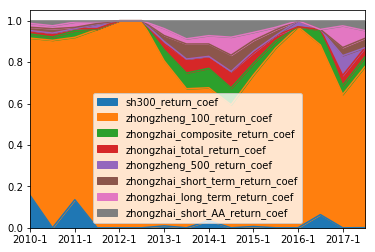

In [53]:
df_half_year[fund_style_coef_list].plot(kind='area')

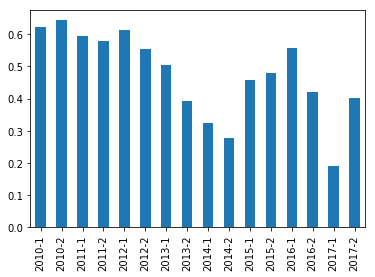

In [54]:
df_half_year['r_squared'].plot(kind='bar')

In [55]:
total_alpha, select_alpha, style_alpha = alpha_calculate(test_fund_data_half_year, 
                                    fund_style_index_list, 'return', benchmark, 'half_year', df_half_year)
# test_fund_data.head()

<Container object of 16 artists>

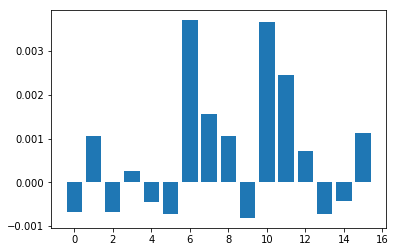

In [56]:
plt.bar(range(len(select_alpha)), select_alpha)

<Container object of 16 artists>

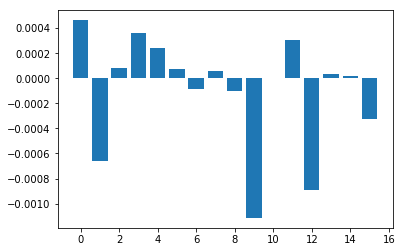

In [57]:
plt.bar(range(len(style_alpha)), style_alpha)

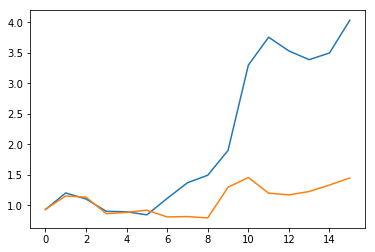

In [129]:
target_values, benchmark_values = fund_nv(test_fund_data_half_year, 'return', 'half_year', benchmark)
plt.plot(target_values)
plt.plot(benchmark_values)